# How to Buy a Van
##### Sean Wade

With upcomming graduation I have been thinking very seriouly about my future.  What will I do for work? How will I handle finding meaningfull relationships with all my cash money?  And most importantly, where will I live? In the midst of all these difficult decisions I keep comming back to one answer.  I need to buy and live in a van. 

There is a lot that goes into making a good van to live in. There is size, space, age, design, and much more.  To find one I have been constantly checking the online classifieds site KSL for any good deals.  I was doing this one night and I thought, "I am better than this".  With a little bit of web scrapping, coding, and machine learning magic I could create a system that would automatically check, update, and analyze new van posts to see if they are a good deal.  All this could be done without me having to do anything so I could have more time to hot tub and eat taquitos.

<div></div>
<img src='images/live-in-van2.jpg' align='left' style='width:325px; height:250px'>
<img src='images/live-in-van3.jpg' align='left' style='width:325px; height:250px'>
<img src='images/live-in-van1.jpg' align='left' style='width:325px; height:250px'>

In [38]:
from bs4 import BeautifulSoup
from urlparse import urljoin
import requests
import re
import string
import tqdm
import itertools
import pandas as pd
import os
import datetime
import sqlite3
from PIL import Image
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

%matplotlib inline

from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://seanwade.com/jupyter.ccs').read())

## Create The Database

Since we will be constantly adding and updating data it only makes sense to use a database.  Writing to a CSV or some other file will be slow and dosn't scale well when I have millions of vans I need to look at.

In [3]:
DATABASE = './data/cars.db'

In [4]:
if False:
    make_table = '''
        CREATE TABLE "vans" (
        "index" INTEGER,
          "body" TEXT,
          "cylinders" TEXT,
          "date_added" TIMESTAMP,
          "dealer_license" TEXT,
          "description" TEXT,
          "drive_type" TEXT,
          "exterior_color" TEXT,
          "exterior_condition" TEXT,
          "fav_num" INTEGER,
          "fuel_type" TEXT,
          "interior_color" TEXT,
          "interior_condition" TEXT,
          "liters" TEXT,
          "make" TEXT,
          "mileage" REAL,
          "model" TEXT,
          "number_of_doors" TEXT,
          "page_views" INTEGER,
          "price" INTEGER,
          "stock_number" TEXT,
          "title_type" TEXT,
          "transmission" TEXT,
          "trim" TEXT,
          "vin" TEXT UNIQUE,
          "year" INTEGER
        );
        '''

    conn = sqlite3.connect(DATABASE)
    cur = conn.cursor()
    cur.execute('DROP TABLE IF EXISTS vans;')
    cur.execute(make_table)

## Scrape the Data

I live in Utah, and for some reason nobody uses Craigslist here...  There is a popular alternative classifieds site here named KSL that I will use for my data.  To get my data I will create a web crawler to scrape the new van data and store it in my database.

In [5]:
def getLastDate(cur):
    ''' Gets the last date added to the database. '''
    cur.execute('SELECT date_added FROM vans ORDER BY date(date_added) DESC')
    most_recent = datetime.datetime.strptime(cur.fetchone()[0], '%Y-%m-%d %H:%M:%S')
    return most_recent

In [6]:
def updateData():
    query = string.Template('https://www.ksl.com/auto/search/index?p=&priceFrom=1&priceTo=20000&miles=25&keyword=van&page=$page_num&cx_navSource=hp_search')
    query_page = requests.get(query.substitute(page_num=0))
    soup = BeautifulSoup(query_page.text)
    BASE_URL = 'https://www.ksl.com'

    conn = sqlite3.connect(DATABASE)
    cur = conn.cursor()
    
    last_date = getLastDate(cur)

    last_page = int(soup.find(title='Go to last page').text)
    data = []
    for page_num in tqdm.tqdm(range(last_page)):
        query_text = query.substitute(page_num=page_num)
        query_page = requests.get(query_text)
        page = BeautifulSoup(query_page.text)
        listings = page.find_all(class_='listing')
        for add in listings:
            try:
                query_page = requests.get(urljoin(BASE_URL, add.find('a')['href']))
                sub_soup = BeautifulSoup(query_page.text)

                car_data = {}

                listing_specs = sub_soup.find('ul', class_='listing-specifications')
                for row in listing_specs.find_all('li'):
                    label = row.find(class_='title').text.lower().replace(':','').replace(' ','_')
                    s = row.find(class_='value').text.rstrip().lower()
                    value = re.sub(r'\W+', '', s)
                    car_data[label] = value

                price = sub_soup.find('h3', class_='price cXenseParse').text
                price = int(''.join(re.findall('\d+', price)))
                car_data['price'] = price

                loc_str = sub_soup.find('h2', class_='location').text
                loc_str = loc_str.split('Posted ')[1]
                date = datetime.datetime.strptime(loc_str, '%B %d, %Y')
                car_data['date_added'] = date
                
                # check if already have info
                if (date - last_date).days < -1:
                    conn.commit()
                    print "Up to date."
                    return

                vdp = sub_soup.find_all('ul', class_='vdp-contact-list')[1]

                page_views =  vdp.find(class_="vdp-info-key", text='Page Views').parent.find(class_="vdp-info-value")
                page_views =  int(re.findall('\d+', page_views.text)[0])
                car_data['page_views'] = page_views

                fav_num = vdp.find(class_="vdp-info-key", text='Favorite of').parent.find(class_="vdp-info-value")
                fav_num =  int(re.findall('\d+', fav_num.text)[0])
                car_data['fav_num'] = fav_num

                description = sub_soup.find('div', class_='short').text.strip().replace('\n',' ').lower()
                car_data['description'] = description
                data.append(car_data)

                # Add to database
                columns = ', '.join(car_data.keys())
                placeholders = ':'+', :'.join(car_data.keys())
                q = 'INSERT INTO vans ({}) VALUES ({})'.format(columns, placeholders)
                try:
                    cur.execute(q, car_data)
                except sqlite3.IntegrityError as e:
                    conn.commit()
                    print "Already have data"
                    return

                # get the images
                try:
                    path =  './images/{}'.format(car_data['vin'])
                    if not os.path.isdir(path):
                        os.mkdir(path)
                        slider = sub_soup.find('ul', class_='slides').find_all('li')
                        for i, pic in enumerate(slider):
                            image = requests.get(pic.img['src'])
                            with open('./images/{}/{}.jpg'.format(car_data['vin'], i), 'wb') as f:
                                f.write(image.content)
                except:
                    print "Error downloading image, skipping..."
            except:
                print "Already in the database..."
        conn.commit()

    conn.commit()
    conn.close()
    return

## Accessing the Data

Now that I have data on data I can query it and check out these beautiful vans (and sift out the garbage).

In [7]:
def findPictures(vin):
    cwd = os.getcwd()
    image_dir = os.path.join(cwd, 'car_images', vin)
    for image in os.listdir(image_dir):
        img = mpimg.imread(os.path.join(cwd,'car_images',vin,image))
        imgplot = plt.imshow(img)
        plt.axis('off')
        plt.show()

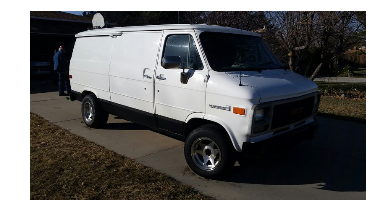

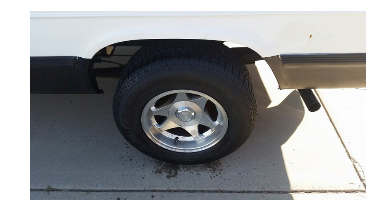

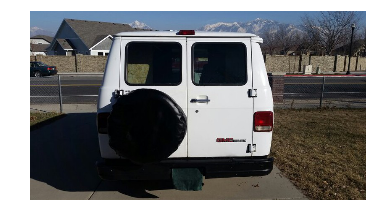

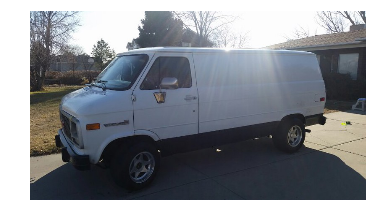

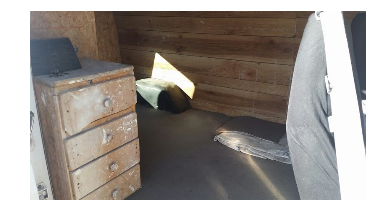

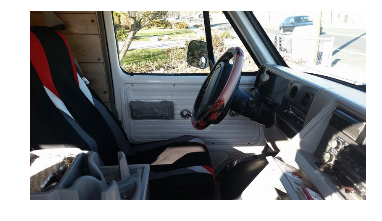

In [8]:
findPictures('1GTDG15H3SF533137')

Now that is a van I could live in!

Next I want to find all the vans that cost less than 5000 and has more than 40 favorites.

In [9]:
conn = sqlite3.connect(DATABASE)
cur = conn.cursor()

In [10]:
df = pd.read_sql_query('SELECT * FROM vans;', conn)

In [11]:
results = pd.read_sql_query('SELECT vin, price, fav_num, description FROM vans WHERE price < 5000 AND fav_num > 40;', conn)

In [12]:
results['vin']

0    1a4gp45r56b615921
1        f44cd8v715555
2    jhmes26773s001704
3    1falp52u7tg313098
4    1jcux7814ft015299
5    1fdke30gsrha07013
Name: vin, dtype: object

## Enter Machine Learning

Now with all this raw data the challange is to teach the computer what it means to be a prime van.  Since I don't got the time or funds to sift through all this data manually and label it I will have to use another huristic.  As I have looked for a van manually I have noticed that the best vans tend to have lots of views and favorites.  The unfortunate part is often once I find these vans they have allready been takin... My idea is to train my model on previous wonder vans with this as a mesure of quality.  Once trained I could then hopefully detect these gems before some hippie snags them up.

In [13]:
# read database into dataFrame
data = pd.read_sql_query('SELECT * FROM vans;', conn)

In [14]:
data.head()

index     body cylinders           date_added dealer_license  \
0  None      van         6  2017-02-14 00:00:00           None   
1  None      van         6  2017-02-14 00:00:00           None   
2  None      van         6  2017-02-14 00:00:00           None   
3  None      van         6  2017-02-14 00:00:00           None   
4  None  minivan         6  2017-02-14 00:00:00           None   

                                         description    drive_type  \
0  801-787-1668. 2009 dodge grand caravan sxt pri...  notspecified   
1  500obo. the van is still in pretty good condit...   2wheeldrive   
2  clean title...very nice....2004 chevrolet vent...           fwd   
3  clean title...very nice....zero accident....20...           fwd   
4  2013 dodge grand caravan sxt, ** accident free...  notspecified   

         exterior_color exterior_condition  fav_num  ...          model  \
0  brightsilvermetallic       notspecified        1  ...   grandcaravan   
1                 other               good        0  ...       astrovan   
2                  gold       notspecified        8  ...        venture   
3                 green       notspecified        4  ...         sienna   
4                 white       notspecified        1  ...   grandcaravan   

  number_of_doors page_views  price stock_number    title_type transmission  \
0    notspecified        383   6999        c5263  salvagetitle    automatic   
1               3         12    500         None    cleantitle    automatic   
2    notspecified        163   1999         None  notspecified    automatic   
3    notspecified        142   1499         None  notspecified    automatic   
4               4         67  11375      1635982  notspecified    automatic   

           trim                vin  year  
0           sxt  2d8hn541x9r658126  2009  
1            lt  1gndm19w9tb192778  1996  
2  notspecified  1gndx03e04d249442  2004  
3            le  4t3zf13cx1u402901  2001  
4           sxt  2c4rdgcg9dr811482  2013  

[5 rows x 26 columns]

## Cleaning the Data

In [15]:
# Drop not so great columns
data.drop(['model', 'index', 'cylinders', 'dealer_license', 'exterior_color', 'interior_color', 'fuel_type', 'liters', 'number_of_doors', 'stock_number','trim'], axis=1, inplace=True)

In [16]:
# CLean messy labels
data.drive_type.replace(['fwd', 'awd', '4wheeldrive'], ['4wd']*3, inplace=True)
data.drive_type.replace(['2wheeldrive', 'rwd'], ['2wd']*2, inplace=True)

### One-Hot Encode All Categorical Data

In [17]:
categorical_data = [
    'body',
    'interior_condition',
    'exterior_condition',
    'title_type',
    'transmission',
    'drive_type',
    'make']

unique_sets = []
for cat in categorical_data:
    unique_sets.append(set(data[cat]))

In [18]:
# store one hot guide for live product
import pickle
unique_sets_dict = dict(zip(categorical_data, unique_sets))
pickle.dump(unique_sets_dict, open('./data/unique_sets_dict.p', 'wb'))

In [19]:
def one_hotify(data, key, unique_set):
    one_hot = np.zeros((data.shape[0], len(unique_set)))
    column_names = []
    for i, item in enumerate(data[key]):
        for j, notion in enumerate(unique_set):
            
            if notion == item:
                one_hot[i, j] = 1
                
    one_hot_df =  pd.DataFrame(one_hot, columns=list(unique_set))
    new_data = pd.concat([data, one_hot_df], axis=1)
    new_data.drop(key, axis=1, inplace=True)
    return new_data

In [20]:
a = one_hotify(data, 'body', unique_sets[0])

In [21]:
for column in categorical_data:
    data = one_hotify(data, column, unique_sets_dict[column])

In [22]:
data.drop(['vin', 'description', 'date_added'], axis=1, inplace=True)

In [23]:
# Drop nan values
data['mileage'] = data['mileage'].replace('notspecified', np.nan)
data['year'] = data['year'].replace('notspecified', np.nan)
data.dropna(axis=0, inplace=True)

### Create Training Labels

In [24]:
labels = data['fav_num'] > 10

In [25]:
data.drop(['fav_num','page_views'], axis=1, inplace=True)

## Make the Models

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [69]:
def plot_confusion_matrix(y_test, y_hat,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_test, y_hat)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [71]:
x_train, x_test, y_train, y_test = train_test_split(data.as_matrix(), labels.as_matrix())

In [72]:
model = LogisticRegression()
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.83763837638376382

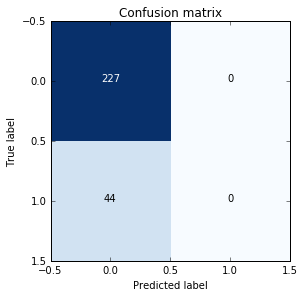

In [73]:
plot_confusion_matrix(y_test, model.predict(x_test))

In [74]:
model = GradientBoostingClassifier()
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.8487084870848709

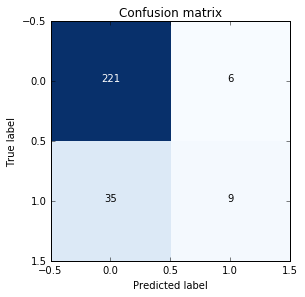

In [75]:
plot_confusion_matrix(y_test, model.predict(x_test))

In [76]:
model = RandomForestClassifier()
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.85239852398523985

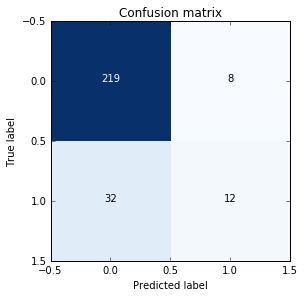

In [77]:
plot_confusion_matrix(y_test, model.predict(x_test))

In [78]:
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.80073800738007384

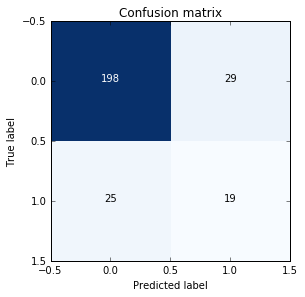

In [79]:
plot_confusion_matrix(y_test, model.predict(x_test))

In [80]:
model = DecisionTreeClassifier(max_depth=2, max_leaf_nodes=15)
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.83763837638376382

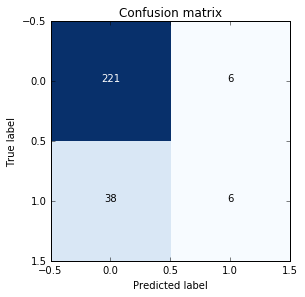

In [81]:
plot_confusion_matrix(y_test, model.predict(x_test))

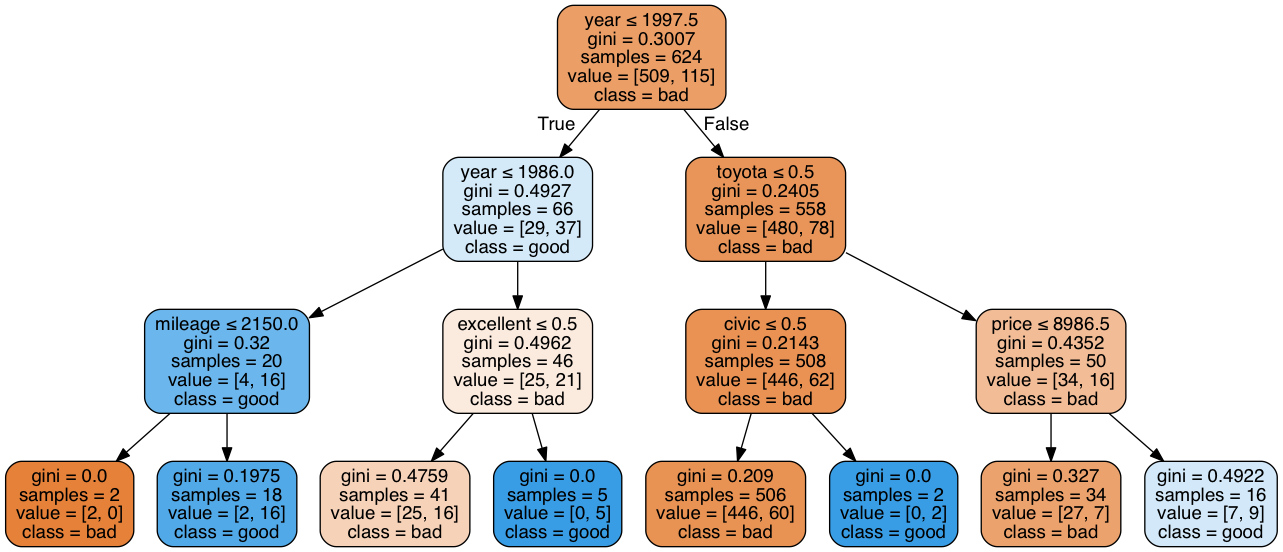

In [100]:
import pydotplus
from IPython.display import Image

dot_data = tree.export_graphviz(model, out_file=None,
                        feature_names=[x.encode('utf-8') for x in data.columns],      
                         class_names=['bad','good'],  
                         filled=True, rounded=True,  
                         special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)
# graph.write_pdf("tree.pdf") 
Image(graph.create_png())  

The best model for this seems to be tree based models, particularly gradient boosted forests.

## The Whole Program

Now that I have all the seperate pieces, I can put it together to create a working program to nitify me of new vans in realtime.  The code for these scripts are in the folder and run on a cron job 4 times a day.  When good deals are found I send them to my email so I can snatch those suckers!  "

<img src='./images/screenshot1.png'>
<img src='./images/screenshot2.png'>